# Deep Learning Option Pricing

Solving the Black-Scholes Partial Differential Equation (PDE), using Physics Informed Neural Networks (PINNs), which governs the price of European options and can be derived from basic principles of hedging, risk neutrality, and no-arbitrage.

Based on following papers:

- "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations" by Maziar Raissi, Paris Perdikaris, and George Em Karniadakis [Link: https://arxiv.org/abs/1711.10561].
- "Physics Informed Neural Network for Option Pricing" by Ashish Dhiman and Yibei Hu [Link: https://arxiv.org/html/2312.06711v1].

The code is inspired by the github repository of Alireza Afzal Afhaei
- [Link: https://github.com/alirezaafzalaghaei/PINN-tutorial]
- [Link: https://github.com/keonly/black-scholes-pinn]
- [Link: https://github.com/rujuldwivedi/Quant-Models]

## Key Assumptions of the Black-Scholes Model:

### 1. Geometric Brownian Motion:
The underlying asset price $S(t)$ follows a stochastic process modeled by:

$$dS(t) = \mu S(t) dt + \sigma S(t) dW(t)$$

where:
- $\mu$ is the drift rate (expected return of the asset).
- $\sigma$ is the volatility of the asset.
- $W(t)$ is a Wiener process (standard Brownian motion).

### 2. No Arbitrage:
There are no arbitrage opportunities in the market, meaning prices adjust to eliminate riskless profit opportunities.

### 3. Constant Interest Rate:
The risk-free interest rate $r$ is constant over time.

## Step 1: Setting Up a Portfolio

We construct a portfolio $\Pi$ consisting of:
- A long position in one option (value $C(S, t)$).
- A short position in $\Delta$ units of the underlying asset $S(t)$, where $\Delta$ is the hedge ratio (the option's delta).

The value of this portfolio is:

$$\Pi = C(S, t) - \Delta S(t)$$

To make the portfolio riskless (i.e., no exposure to the stochastic changes in $S$), we choose $\Delta$ to cancel out the stochastic part of the option's value, such that:

$$d\Pi = dC - \Delta dS$$

From **Ito's Lemma**, the differential of the option price $C(S, t)$ is given by:

$$dC = \frac{\partial C}{\partial t} dt + \frac{\partial C}{\partial S} dS + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2S^2dt$$

Substituting the stochastic process for $dS(t)$, we get:

$$dC = \frac{\partial C}{\partial t} dt + \frac{\partial C}{\partial S} (\mu S dt + \sigma S dW) + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 dt$$

Now, choosing $\Delta = \frac{\partial C}{\partial S}$ (i.e., delta hedging), the stochastic terms involving $dW$ cancel out, leaving us with:

$$d\Pi = \frac{\partial C}{\partial t} dt + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 dt$$

Since this portfolio is riskless, by the principle of no arbitrage, it must earn the risk-free rate $r$. Therefore, the portfolio's value $\Pi$ must satisfy:

$$d\Pi = r \Pi dt$$

Substituting the value of: $$\Pi = C(S, t) - \Delta S = C(S, t) - \frac{\partial C}{\partial S} S$$

We get:

$$\frac{\partial C}{\partial t} + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 + rS \frac{\partial C}{\partial S} - rC = 0$$

This is the **Black-Scholes Partial Differential Equation**.

## Step 2: Boundary Conditions

For a European call option, the boundary conditions are:

- **At maturity** $t = T$, the option payoff is given by:
  
$$C(S, T) = \max(S_T - X, 0)$$

where $X$ is the strike price.

## Problem Statement

We have been given a PDE:
$$
\dfrac{\partial C}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 C}{\partial S^2} + rS\dfrac{\partial C}{\partial S} -rC = 0
$$

and boundary conditions:
$$
\begin{align*}
   &C(t, 0) = 0 &&\text{for all $t \geq 0$}\\
   &C(t, S) \to S - K &&\text{for all $t \geq 0$ as $S \to \infty$}\\
   &C(T, S) = \max\{S - K, 0\}
\end{align*}
$$

- Independent variables: $t, S$ (input)
- Dependent variables: $C$ (outputs)

### Importing the libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as tgrad
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as si

#### Using CUDA (GPU) for faster computation, if available

In [2]:
# defining cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Defining the constants and the boundary conditions

In [3]:
K = 100              # Strike Price
r = 0.05            # Interest Rate
sigma = 0.3        # Annual volatility of asset
T = 2               # Time to maturity
S_range = [0, 400]  # Input ranges for asset price
t_range = [0, T]    # Input ranges for time
gs = lambda x: np.fmax(x - K, 0)  # Instrinsic value of call option

#### Defining the call option price (true value)

C:\Users\Rujul\AppData\Local\Temp\ipykernel_8896\3726250628.py:5: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\Rujul\AppData\Local\Temp\ipykernel_8896\3726250628.py:5: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


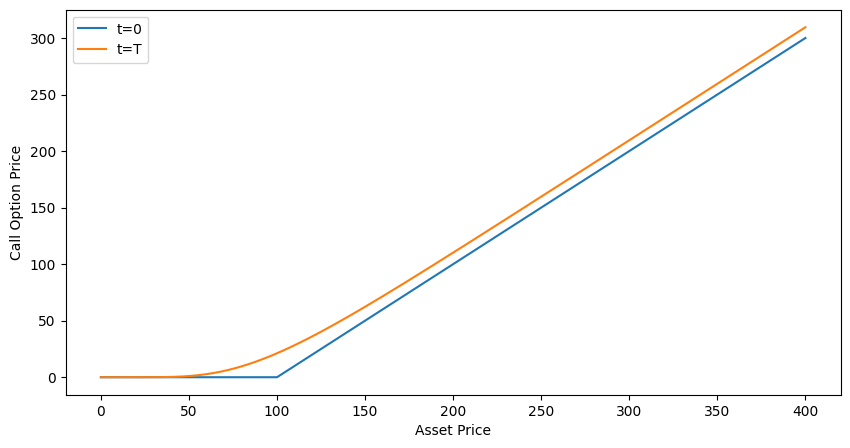

In [4]:
# Black-Scholes formula for call option

def black_scholes_call_div(X, K, T, r, sigma):
    S = X[:, 1]
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call

# Plotting the black scholes for time = 0 and time t = 1

plt.figure(figsize=(10, 5))
S = np.linspace(S_range[0], S_range[1], 1000)
X = np.zeros((S.shape[0], 2))
X[:, 1] = S
plt.plot(S, black_scholes_call_div(X, K, 0, r, sigma), label='t=0')
plt.plot(S, black_scholes_call_div(X, K, T, r, sigma), label='t=T')
plt.xlabel('Asset Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.show()

##### First we define the samplers for datapoints to be used for the training process.
##### Uniform distribution is used to generate the data points.

In [7]:
# Data generation functions

# Data for the differential equation problem (The problem is to find the value of the option at any time)
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1))
    return X, y

# Data for the expiration value problem (The problem is to find the value of the option at expiration)
def get_evp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)
    
    return X, y

# Data for the boundary value problem (The problem is to find the value of the option at the boundaries)
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = black_scholes_call_div(X2, K, T, r, sigma).reshape(-1, 1)
    
    return X1, y1, X2, y2

##### The resulting points plot looks like this.
##### Here, 1000 points are sampled for expirational / boundary values, and 5000 points are sampled for collocation.

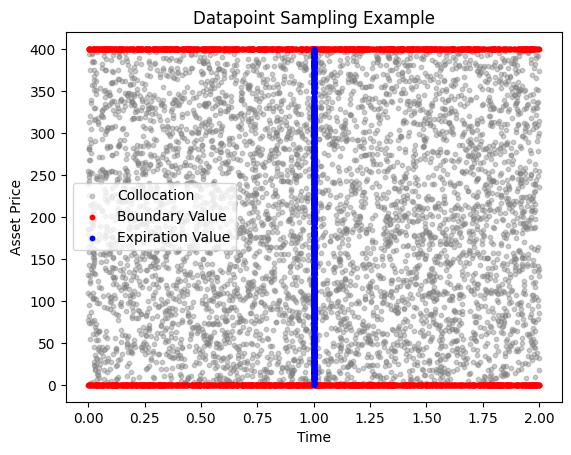

In [8]:
X1, _ = get_diff_data(5000)
X21, _, X22, _ = get_bvp_data(1000)
X3, _ = get_evp_data(1000)

plt.scatter(X1[:,0], X1[:,1], color='gray', s=10, alpha=0.4, label='Collocation')
plt.scatter(X21[:,0], X21[:,1], color='red', s=10, label='Boundary Value')
plt.scatter(X22[:,0], X22[:,1], color='red', s=10)
plt.scatter(X3[:,0], X3[:,1], color='blue', s=10, label='Expiration Value')

plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.title('Datapoint Sampling Example')
plt.legend()

plt.show()

#### Now we implement the neural network.

In [9]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):

        # First we define the input layer with 2 neurons (time and asset price)
        super(PINN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Then we define hidden layers with 5 neurons each
        self.hidden_layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.hidden_layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer4 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer5 = nn.Linear(self.hidden_dim, self.hidden_dim)

        # Finally we define the output layer with 1 neuron (the value of the option)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # We use the ReLU activation function for the hidden layers
        self.activation = torch.relu

        # xavier is an initialization method that sets the weights of the layers to be normally distributed with a mean of 0
        # and a variance of 2/(number of input neurons + number of output neurons) 

        torch.nn.init.xavier_normal_(self.hidden_layer1.weight.data) 
        torch.nn.init.xavier_normal_(self.hidden_layer2.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer3.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer4.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer5.weight.data)
        torch.nn.init.xavier_normal_(self.output_layer.weight.data)


    # The forward function defines the forward pass of the neural network
    def forward(self, x):
        inputs = x
        layer1_out = self.activation(self.hidden_layer1(inputs))
        layer2_out = self.activation(self.hidden_layer2(layer1_out))
        layer3_out = self.activation(self.hidden_layer3(layer2_out))
        layer4_out = self.activation(self.hidden_layer4(layer3_out))
        layer5_out = self.activation(self.hidden_layer5(layer4_out))
        out = self.output_layer(layer5_out)
        return out
    

#### We setup the model architecture with following hyperparameters, and start training.

In [10]:
# We define the model with 2 input neurons, 128 hidden neurons and 1 output neuron
model = PINN(2, 128, 1)

model.to(device)

# We take epoch to be 10000
n_epochs = 5000

# We take the number of samples for each problem to be 5000
samples = {"pde": 5000, "bvp":5000, "evp":5000}

# We define the loss function to be the mean squared error
criterion = nn.MSELoss()

# We define the optimizer to be the Adam optimizer with a learning rate of 1e-5
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#### Training the model for 10000 epochs and calculating the loss

In [11]:
loss_hist = []

for epoch in range(n_epochs):

    # Loss based on PDE
    X1, y1 = get_diff_data(samples['pde'])
    X1 = torch.from_numpy(X1).float().requires_grad_().to(device)
    y1 = torch.from_numpy(y1).float().to(device)

    y1_hat = model(X1)
    
    grads_1 = tgrad.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(device), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dV_dt, dV_dS = grads_1[:, 0].view(-1, 1), grads_1[:, 1].view(-1, 1)
    grads_2 = tgrad.grad(dV_dS, X1, grad_outputs=torch.ones(dV_dS.shape).to(device), create_graph=True, only_inputs=True)[0]
    d2V_dS2 = grads_2[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    pde_loss = criterion(-dV_dt, 0.5*((sigma*S1)**2)*d2V_dS2 + r*S1*dV_dS - r*y1_hat)
    
    # Loss based on boundary conditions
    X21, y21, X22, y22 = get_bvp_data(samples['bvp'])
    
    X21 = torch.from_numpy(X21).float().to(device)
    y21 = torch.from_numpy(y21).float().to(device)
    
    X22 = torch.from_numpy(X22).float().to(device)
    y22 = torch.from_numpy(y22).float().to(device)

    y21_hat = model(X21)
    bvp1_loss = criterion(y21, y21_hat)
    
    y22_hat = model(X22)
    bvp2_loss = criterion(y22, y22_hat)
    
    # Loss based on expirational conditions
    X3, y3 = get_evp_data(samples['evp'])
    
    X3 = torch.from_numpy(X3).float().to(device)
    y3 = torch.from_numpy(y3).float().to(device)
    
    y3_hat = model(X3)
    evp_loss = criterion(y3, y3_hat)
    
    # Combining the loss functions
    loss = pde_loss + bvp1_loss + bvp2_loss + evp_loss
    
    # Backpropagation and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BVP1 Loss: {bvp1_loss.item():.5f}, BVP2 Loss: {bvp2_loss.item():.5f}, EVP Loss: {evp_loss.item():.5f},')
    

0/5000 PDE Loss: 0.00287, BVP1 Loss: 0.01870, BVP2 Loss: 99563.60156, EVP Loss: 23770.76953,
500/5000 PDE Loss: 0.00051, BVP1 Loss: 0.00003, BVP2 Loss: 52235.55078, EVP Loss: 11190.88770,
1000/5000 PDE Loss: 0.00686, BVP1 Loss: 0.00007, BVP2 Loss: 3331.84009, EVP Loss: 1089.80066,
1500/5000 PDE Loss: 0.09627, BVP1 Loss: 0.00000, BVP2 Loss: 190.60965, EVP Loss: 1483.27356,
2000/5000 PDE Loss: 1.02358, BVP1 Loss: 0.00003, BVP2 Loss: 163.51794, EVP Loss: 1285.98987,
2500/5000 PDE Loss: 7.08397, BVP1 Loss: 0.00003, BVP2 Loss: 129.22690, EVP Loss: 907.54883,
3000/5000 PDE Loss: 16.41246, BVP1 Loss: 0.00003, BVP2 Loss: 95.50829, EVP Loss: 563.34625,
3500/5000 PDE Loss: 28.29597, BVP1 Loss: 0.00001, BVP2 Loss: 76.90024, EVP Loss: 304.22015,
4000/5000 PDE Loss: 33.10023, BVP1 Loss: 0.00001, BVP2 Loss: 48.82691, EVP Loss: 137.80785,
4500/5000 PDE Loss: 25.58009, BVP1 Loss: 0.00001, BVP2 Loss: 33.78279, EVP Loss: 55.55204,


#### Finally, we plot our results to check the performance of the model.

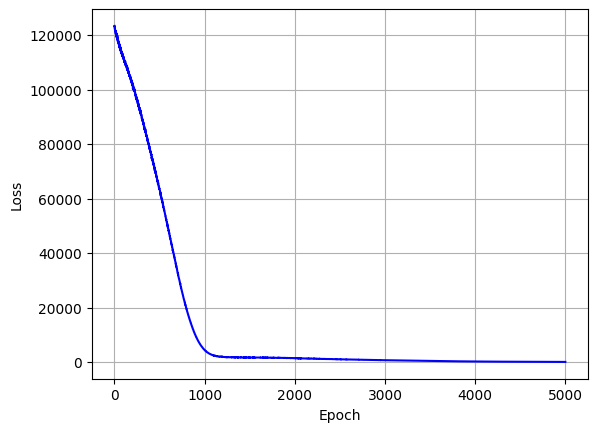

In [12]:
x_len = np.arange(len(loss_hist))
plt.plot(x_len, loss_hist, c='blue', label="Train-set Loss")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Comparing the results with the Black-Scholes formula

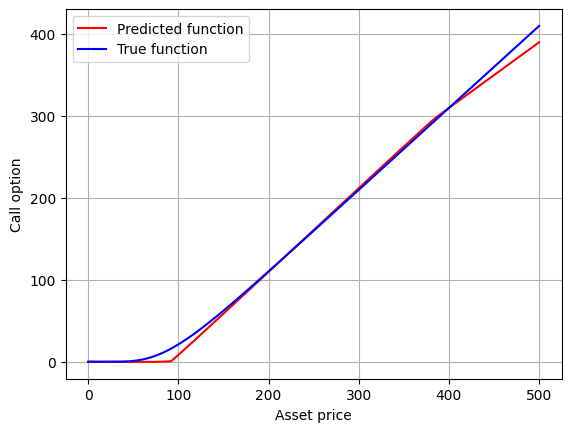

In [13]:
# This function resolves redundant legend issues when using matplotlib library.
# Retrieved from https://stackoverflow.com/a/56253636

# The below function uses legends without duplicate labels which helps in better visualization
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

np.seterr(divide = 'ignore')
fig, ax = plt.subplots()

X_cmp = np.concatenate([0.5*np.ones((1000, 1)),
                        np.linspace(0, 500, num=1000).reshape(-1, 1)], axis=1)
Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_().to(device)).cpu().detach()
Y_true = black_scholes_call_div(X_cmp, K, T, r, sigma).reshape(-1, 1)

X_cmp = np.linspace(0, 500, num=1000)

ax.plot(X_cmp, Y_pred, c='red', label="Predicted function")
ax.plot(X_cmp, Y_true, c='blue', label="True function")

legend_without_duplicate_labels(ax)

plt.grid()
plt.xlabel('Asset price')
plt.ylabel('Call option')

plt.show()

#### Plotting the predicted price value against the asset price and time

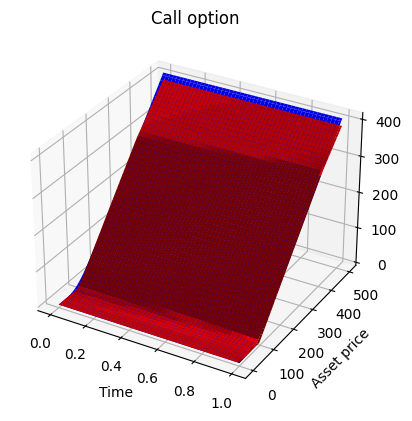

In [14]:
# Plotting the predicted function with respect to time and asset price for the call option in 3D

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X1 = np.linspace(0, 1, num=100)
X2 = np.linspace(0, 500, num=100)
X1, X2 = np.meshgrid(X1, X2)
X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)

Y_pred = model(torch.from_numpy(X).float().requires_grad_().to(device)).cpu().detach().numpy().reshape(100, 100)
Y_true = black_scholes_call_div(X, K, T, r, sigma).reshape(100, 100)

ax.plot_surface(X1, X2, Y_pred, color='red', label="Predicted function")
ax.plot_surface(X1, X2, Y_true, color='blue', label="True function")

plt.xlabel('Time')
plt.ylabel('Asset price')
plt.title('Call option')
# plt.legend()


plt.show()